# ***Resnet Based Approach***
This approach is pretty straightforward generating an embedding using pretrained model and just calculate distanace of those embeddings based on cosine similarity etc. Based on these distance metrics we can calculate similarity.

Preprocessing images...
Extracting features...
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 73ms/step
Finding nearest neighbors...


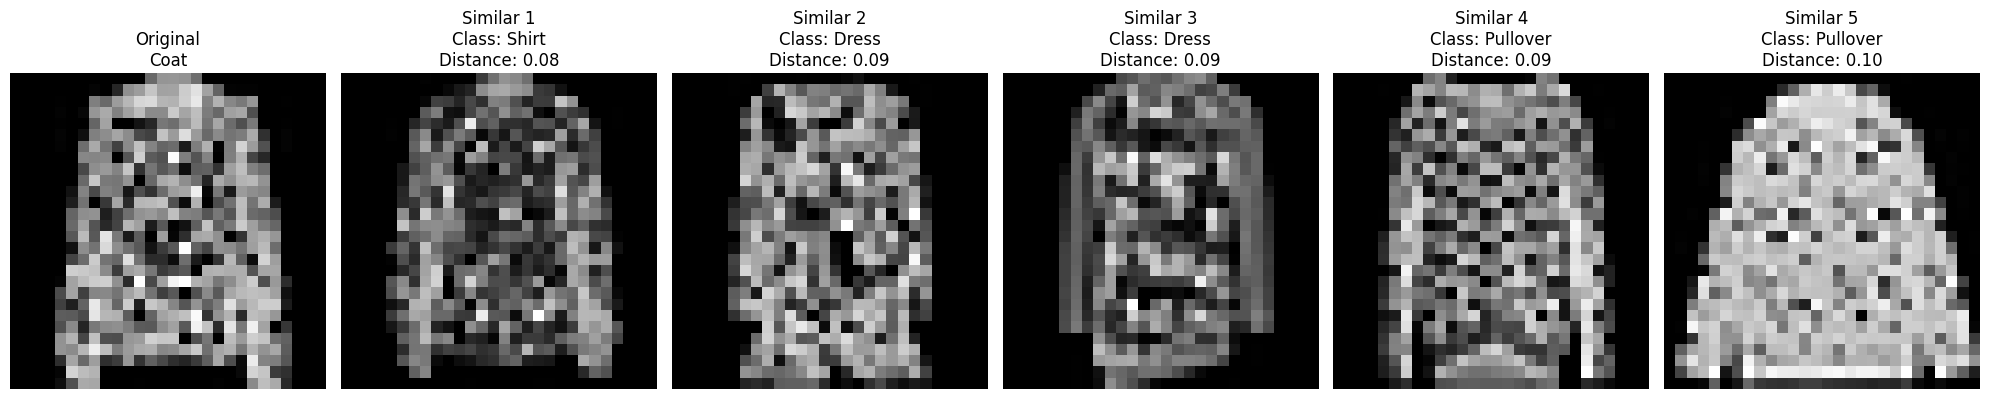

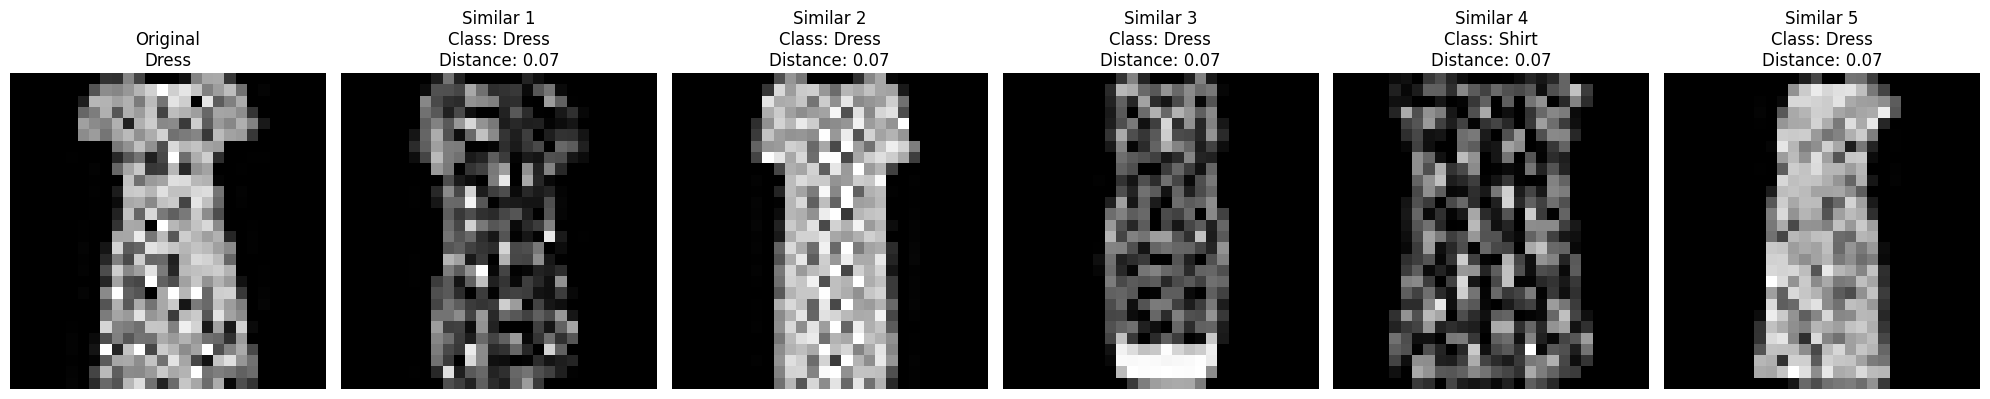

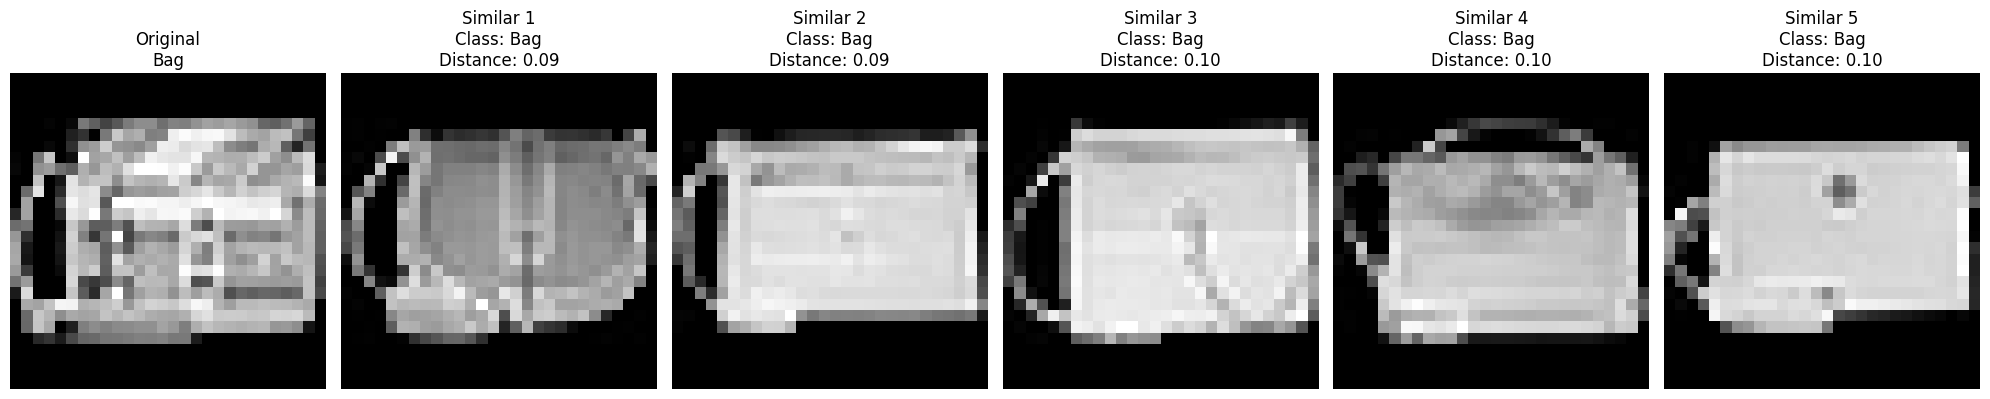

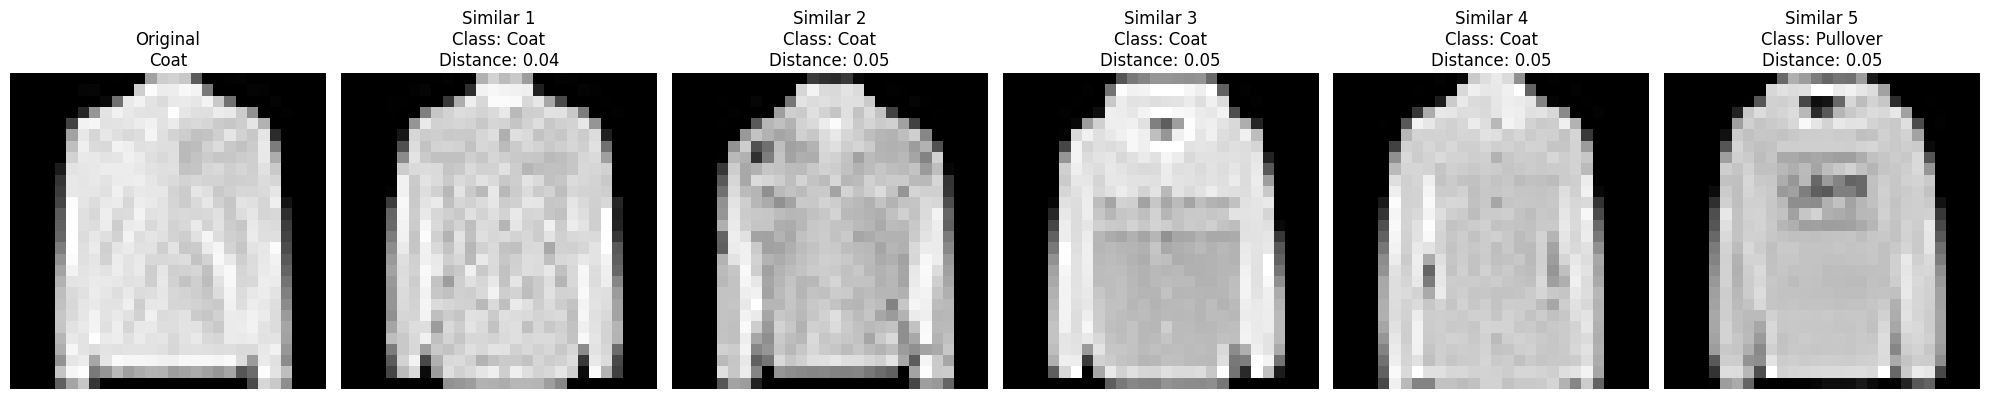

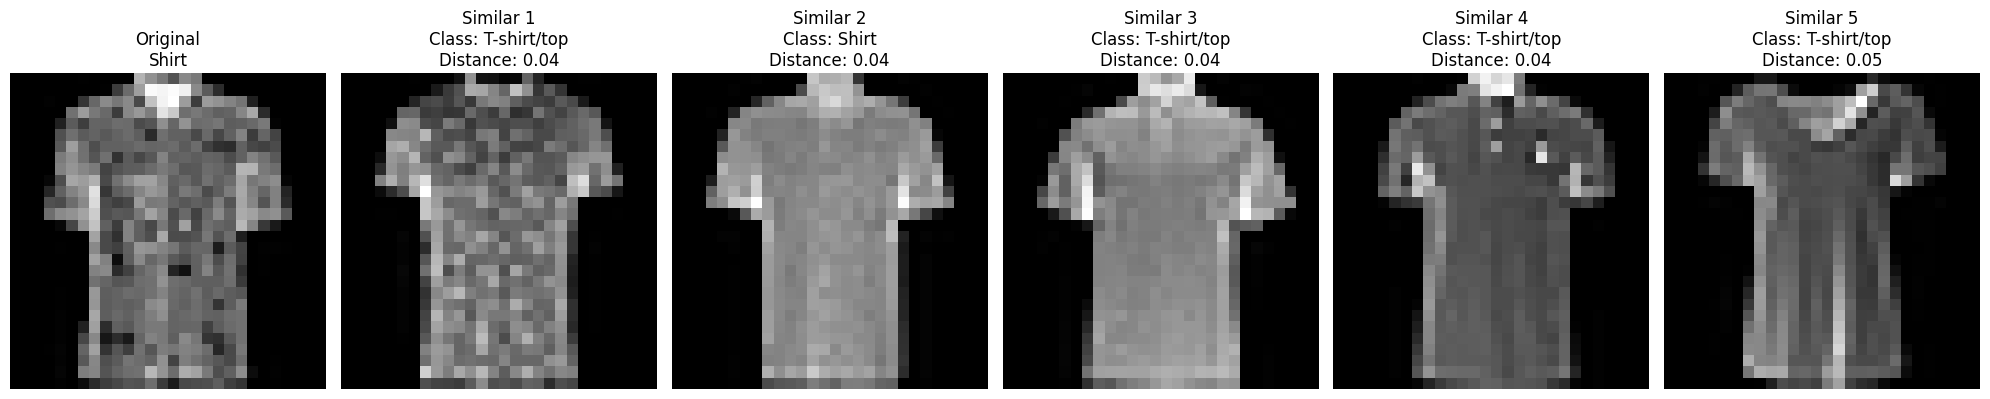


Calculating retrieval metrics...

Overall Metrics Summary:
----------------------

At K = 1:
Precision: 0.778
Recall: 0.002
F1-score: 0.004

At K = 5:
Precision: 0.737
Recall: 0.009
F1-score: 0.018

At K = 10:
Precision: 0.712
Recall: 0.018
F1-score: 0.035

At K = 20:
Precision: 0.681
Recall: 0.034
F1-score: 0.065

Per-class Metrics at K=20:
----------------

T-shirt/top:
Precision: 0.622
Recall: 0.033
F1-score: 0.063

Trouser:
Precision: 0.928
Recall: 0.042
F1-score: 0.081

Pullover:
Precision: 0.478
Recall: 0.024
F1-score: 0.045

Dress:
Precision: 0.750
Recall: 0.037
F1-score: 0.070

Coat:
Precision: 0.570
Recall: 0.029
F1-score: 0.055

Sandal:
Precision: 0.633
Recall: 0.032
F1-score: 0.062

Shirt:
Precision: 0.368
Recall: 0.018
F1-score: 0.035

Sneaker:
Precision: 0.838
Recall: 0.041
F1-score: 0.078

Bag:
Precision: 0.681
Recall: 0.036
F1-score: 0.068

Ankle boot:
Precision: 0.906
Recall: 0.046
F1-score: 0.088


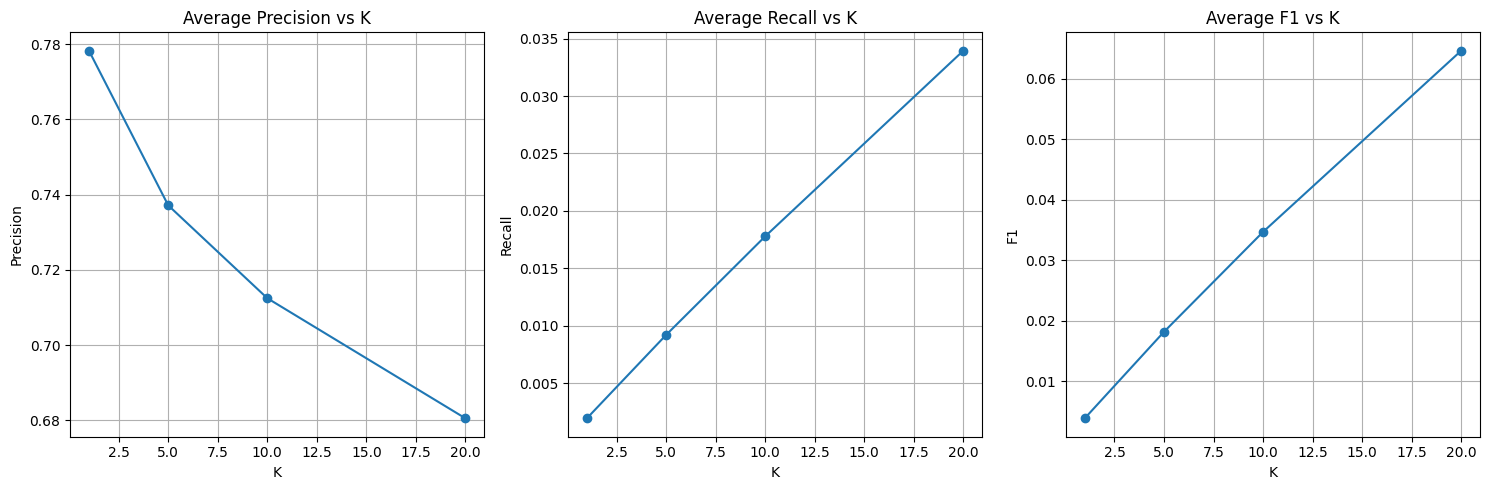

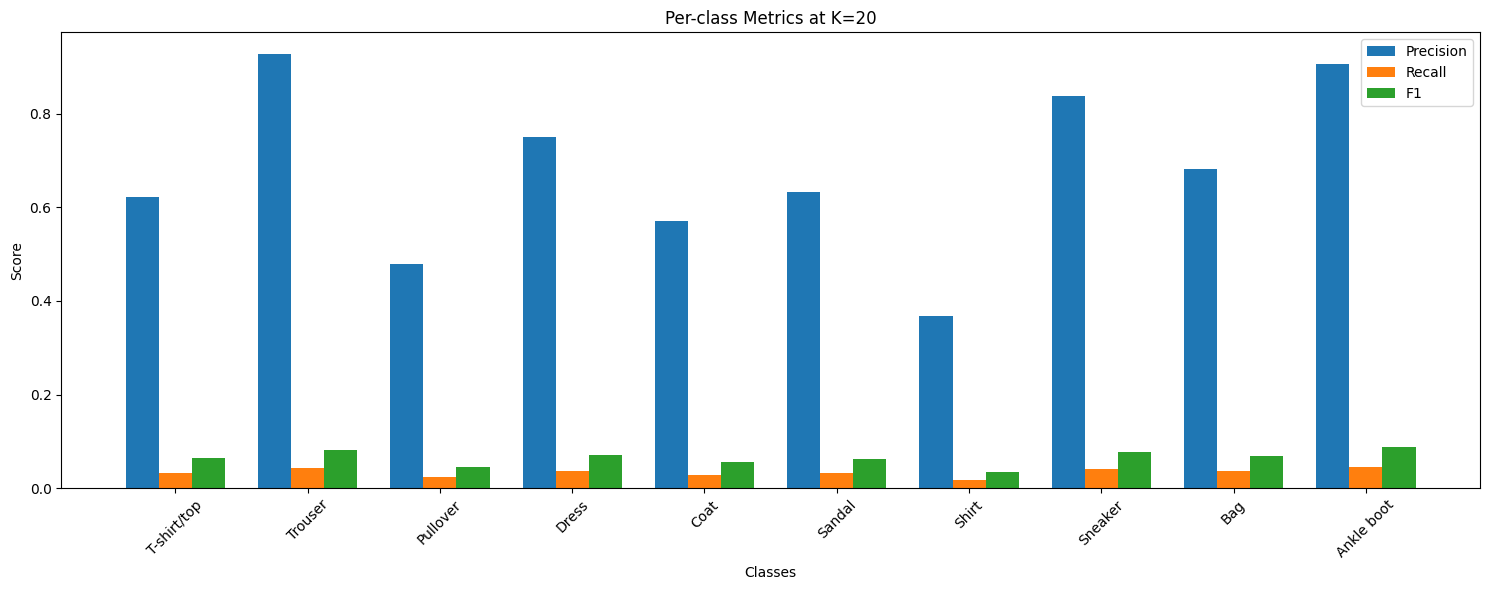


Generating t-SNE visualization...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.039142
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.118317
[t-SNE] KL divergence after 1000 iterations: 0.428363


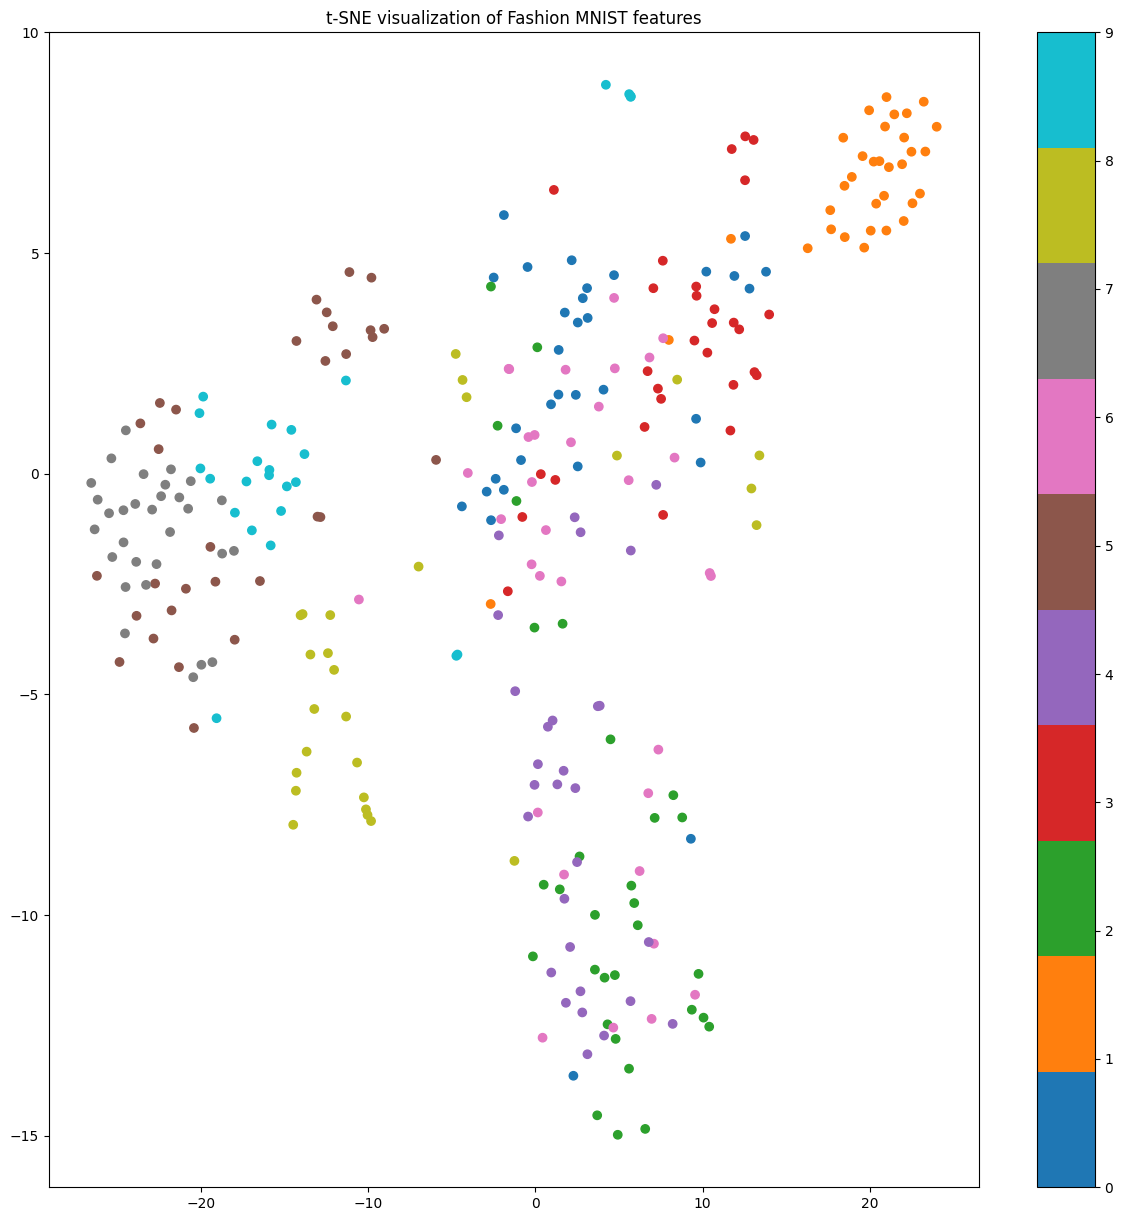

In [ ]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import random
from collections import defaultdict

# Load Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Class names for Fashion MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Preprocessing Dataset for processing through model.
def preprocess_fashion_mnist(images, sample_size=5000):
    # Take a subset of images
    images = images[:sample_size]

    # Add channel dimension first (convert from (28, 28) to (28, 28, 1))
    images = np.expand_dims(images, axis=-1)

    # Convert to float32 and scale to [0, 1]
    images = images.astype('float32') / 255.0

    processed_images = []
    for img in images:
        # Resize to 224x224
        img_resized = tf.image.resize(img, [224, 224])
        # Convert to RGB by repeating the channel 3 times
        img_rgb = tf.image.grayscale_to_rgb(img_resized)
        processed_images.append(img_rgb)

    # Convert to numpy array and preprocess for ResNet50
    processed_images = np.array(processed_images)
    processed_images = preprocess_input(processed_images)

    return processed_images
# Passing through the model to Generate embeddings.
def extract_features(images, model):
    features = model.predict(images, batch_size=32)
    features_flatten = features.reshape(features.shape[0], -1)
    # Normalize features
    normalized_features = features_flatten / np.linalg.norm(features_flatten, axis=1)[:, np.newaxis]
    return normalized_features
# Function to plot similar images.
def plot_similar_images(original_idx, indices, distances, images, labels=None):
    plt.figure(figsize=(20, 4))
    plt.subplot(1, 6, 1)
    plt.imshow(images[original_idx], cmap='gray')
    plt.title(f'Original\n{class_names[labels[original_idx]]}' if labels is not None else 'Original')
    plt.axis('off')

    for i in range(5):
        plt.subplot(1, 6, i + 2)
        plt.imshow(images[indices[i]], cmap='gray')
        if labels is not None:
            plt.title(f'Similar {i+1}\nClass: {class_names[labels[indices[i]]]}\nDistance: {distances[i]:.2f}')
        else:
            plt.title(f'Similar {i+1}\nDistance: {distances[i]:.2f}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
# tsne plot based on distance metric
def visualize_tsne(features, images, labels, n_samples=300):
    # Reduce dimensions using PCA first
    pca = PCA(n_components=50)
    features_pca = pca.fit_transform(features[:n_samples])

    # Apply t-SNE
    tsne = TSNE(n_components=2, verbose=1, metric='euclidean')
    tsne_results = tsne.fit_transform(features_pca)

    # Plot results
    plt.figure(figsize=(15, 15))
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=labels[:n_samples], cmap='tab10')
    plt.colorbar(scatter)
    plt.title('t-SNE visualization of Fashion MNIST features')
    plt.show()
# trying to calculate scores for this dataset despite the dataset being unlabelled in terms of similarity.
def calculate_retrieval_metrics(features, labels, k_values=[1, 5, 10, 20]):
    """Calculate precision, recall, and F1-score for image retrieval"""
    n_samples = len(features)
    similarity_matrix = np.dot(features, features.T)

    # Initialize metrics storage
    metrics = {
        'overall': {k: {'precision': [], 'recall': [], 'f1': []} for k in k_values},
        'per_class': {i: {k: {'precision': [], 'recall': [], 'f1': []}
                         for k in k_values}
                     for i in range(len(class_names))}
    }

    for i in range(n_samples):
        query_similarities = similarity_matrix[i]
        query_class = labels[i]

        # Get relevant items (same class as query)
        relevant_items = set(np.where(labels == query_class)[0])
        relevant_items.remove(i)
        n_relevant = len(relevant_items)

        # Sort by similarity
        sorted_indices = np.argsort(-query_similarities)
        sorted_indices = sorted_indices[sorted_indices != i]

        for k in k_values:
            retrieved_items = set(sorted_indices[:k])
            retrieved_relevant = retrieved_items.intersection(relevant_items)

            # Calculate metrics
            precision = len(retrieved_relevant) / k if k > 0 else 0
            recall = len(retrieved_relevant) / n_relevant if n_relevant > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

            # Store overall metrics
            metrics['overall'][k]['precision'].append(precision)
            metrics['overall'][k]['recall'].append(recall)
            metrics['overall'][k]['f1'].append(f1)

            # Store per-class metrics
            metrics['per_class'][query_class][k]['precision'].append(precision)
            metrics['per_class'][query_class][k]['recall'].append(recall)
            metrics['per_class'][query_class][k]['f1'].append(f1)

    return metrics
# Function for plotting similarity.
def plot_metrics(metrics, k_values):
    # Plot overall metrics
    plt.figure(figsize=(15, 5))
    metric_names = ['precision', 'recall', 'f1']

    for i, metric in enumerate(metric_names, 1):
        plt.subplot(1, 3, i)
        values = [np.mean(metrics['overall'][k][metric]) for k in k_values]
        plt.plot(k_values, values, 'o-')
        plt.title(f'Average {metric.capitalize()} vs K')
        plt.xlabel('K')
        plt.ylabel(metric.capitalize())
        plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot per-class metrics for max K
    max_k = max(k_values)
    plt.figure(figsize=(15, 6))
    x = np.arange(len(class_names))
    width = 0.25

    class_precisions = [np.mean(metrics['per_class'][i][max_k]['precision']) for i in range(len(class_names))]
    class_recalls = [np.mean(metrics['per_class'][i][max_k]['recall']) for i in range(len(class_names))]
    class_f1s = [np.mean(metrics['per_class'][i][max_k]['f1']) for i in range(len(class_names))]

    plt.bar(x - width, class_precisions, width, label='Precision')
    plt.bar(x, class_recalls, width, label='Recall')
    plt.bar(x + width, class_f1s, width, label='F1')

    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title(f'Per-class Metrics at K={max_k}')
    plt.xticks(x, class_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
# Printing metrics.
def print_metrics_summary(metrics, k_values):
    print("\nOverall Metrics Summary:")
    print("----------------------")
    for k in k_values:
        print(f"\nAt K = {k}:")
        print(f"Precision: {np.mean(metrics['overall'][k]['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['overall'][k]['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['overall'][k]['f1']):.3f}")

    print("\nPer-class Metrics at K={}:".format(max(k_values)))
    print("----------------")
    max_k = max(k_values)
    for i, class_name in enumerate(class_names):
        print(f"\n{class_name}:")
        print(f"Precision: {np.mean(metrics['per_class'][i][max_k]['precision']):.3f}")
        print(f"Recall: {np.mean(metrics['per_class'][i][max_k]['recall']):.3f}")
        print(f"F1-score: {np.mean(metrics['per_class'][i][max_k]['f1']):.3f}")
# Using main to call all the functions and computer similarity using generated embeddings using resnet-50.
def main(sample_size=4000):
    # Initialize ResNet50 model
    model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

    # Preprocess images
    print("Preprocessing images...")
    processed_images = preprocess_fashion_mnist(x_train, sample_size)

    # Extract features
    print("Extracting features...")
    features = extract_features(processed_images, model)

    # Find nearest neighbors
    print("Finding nearest neighbors...")
    neighbors = NearestNeighbors(n_neighbors=6, algorithm='brute', metric='euclidean').fit(features)

    # Show similar images for random examples
    for _ in range(5):
        random_idx = random.randint(0, sample_size-1)
        distances, indices = neighbors.kneighbors([features[random_idx]])
        plot_similar_images(random_idx, indices[0][1:], distances[0][1:],
                          x_train[:sample_size], y_train[:sample_size])

    # Calculate and display metrics
    print("\nCalculating retrieval metrics...")
    k_values = [1, 5, 10, 20]
    metrics = calculate_retrieval_metrics(features, y_train[:sample_size], k_values)
    print_metrics_summary(metrics, k_values)
    plot_metrics(metrics, k_values)

    # Visualize using t-SNE
    print("\nGenerating t-SNE visualization...")
    visualize_tsne(features, x_train[:sample_size], y_train[:sample_size])

if __name__ == "__main__":
    main(sample_size=4000)